In [1]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.spatial import distance
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mir_counts = pd.read_csv("mir_deseq_scaled.csv", index_col=0)
mir_counts.head()

,TCGA-BP-4160-01A,TCGA-BP-4781-01A,TCGA-B0-4821-01A,TCGA-CJ-4872-01A,TCGA-B8-5553-01A,TCGA-BP-5176-01A,TCGA-CJ-5671-01A,TCGA-A3-A6NJ-01A,TCGA-B8-4153-01B,TCGA-B0-4847-01A,...,TCGA-BP-4971-01A,TCGA-B0-4945-01A,TCGA-CZ-5452-01A,TCGA-CZ-5452-11A,TCGA-AS-3777-01A,TCGA-DV-A4VX-01A,TCGA-B0-4838-01A,TCGA-B0-5399-01A,TCGA-BP-4163-01A,TCGA-AK-3451-01A
hsa-mir-4690,-0.397466,-0.397466,2.644347,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,...,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,0.967351,-0.397466,-0.397466
hsa-mir-3124,-0.420873,-0.420873,-0.420873,2.344919,1.725486,-0.420873,1.776232,-0.420873,1.238517,-0.420873,...,-0.420873,-0.420873,1.816599,-0.420873,-0.420873,2.540710,-0.420873,-0.420873,-0.420873,-0.420873
hsa-mir-6715b,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,...,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630
hsa-mir-6735,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,...,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,2.852970,-0.349429,-0.349429,-0.349429,-0.349429
hsa-mir-4680,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,...,-0.346729,2.273226,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,1.073429,2.541817,3.236505


In [5]:
## Read the labels dataset as pandas dataframe:
meta = pd.read_csv('data_clinical_patient.txt', sep="\t", header=0, skiprows=[0,1,2,3])
meta.head()

,OTHER_PATIENT_ID,PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
0,2B1DEA0A-6D55-4FDD-9C1C-0D9FBE03BD78,TCGA-3Z-A93Z,2014-11-11,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,MALE,BLACK OR AFRICAN AMERICAN,...,YES,[Not Available],[Not Available],NO,3Z,Kidney,0:LIVING,12.65,0:DiseaseFree,12.65
1,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,TCGA-6D-AA2E,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,BLACK OR AFRICAN AMERICAN,...,YES,[Not Available],[Not Available],NO,6D,Kidney,0:LIVING,11.89,0:DiseaseFree,11.89
2,9fb55e0b-43d8-40a3-8ef2-d198e6290551,TCGA-A3-3306,8/23/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,36.79,0:DiseaseFree,36.79
3,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,TCGA-A3-3307,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,47.17,0:DiseaseFree,47.17
4,3cbca837-f5a7-4a87-8f02-c59eac232d5a,TCGA-A3-3308,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,WHITE,...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,0.53,0:DiseaseFree,0.53


In [6]:
mir_counts.columns = [i[:12] for i in mir_counts.columns]
mir_counts.columns


Index(['TCGA-BP-4160', 'TCGA-BP-4781', 'TCGA-B0-4821', 'TCGA-CJ-4872',
       'TCGA-B8-5553', 'TCGA-BP-5176', 'TCGA-CJ-5671', 'TCGA-A3-A6NJ',
       'TCGA-B8-4153', 'TCGA-B0-4847',
       ...
       'TCGA-BP-4971', 'TCGA-B0-4945', 'TCGA-CZ-5452', 'TCGA-CZ-5452',
       'TCGA-AS-3777', 'TCGA-DV-A4VX', 'TCGA-B0-4838', 'TCGA-B0-5399',
       'TCGA-BP-4163', 'TCGA-AK-3451'],
      dtype='object', length=590)

In [7]:
mir_counts.head()

,TCGA-BP-4160,TCGA-BP-4781,TCGA-B0-4821,TCGA-CJ-4872,TCGA-B8-5553,TCGA-BP-5176,TCGA-CJ-5671,TCGA-A3-A6NJ,TCGA-B8-4153,TCGA-B0-4847,...,TCGA-BP-4971,TCGA-B0-4945,TCGA-CZ-5452,TCGA-CZ-5452,TCGA-AS-3777,TCGA-DV-A4VX,TCGA-B0-4838,TCGA-B0-5399,TCGA-BP-4163,TCGA-AK-3451
hsa-mir-4690,-0.397466,-0.397466,2.644347,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,...,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,-0.397466,0.967351,-0.397466,-0.397466
hsa-mir-3124,-0.420873,-0.420873,-0.420873,2.344919,1.725486,-0.420873,1.776232,-0.420873,1.238517,-0.420873,...,-0.420873,-0.420873,1.816599,-0.420873,-0.420873,2.540710,-0.420873,-0.420873,-0.420873,-0.420873
hsa-mir-6715b,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,...,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630,-0.172630
hsa-mir-6735,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,...,-0.349429,-0.349429,-0.349429,-0.349429,-0.349429,2.852970,-0.349429,-0.349429,-0.349429,-0.349429
hsa-mir-4680,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,...,-0.346729,2.273226,-0.346729,-0.346729,-0.346729,-0.346729,-0.346729,1.073429,2.541817,3.236505


In [8]:
mir_counts = mir_counts.loc[:,~mir_counts.columns.duplicated()]
mir_counts.shape

(800, 515)

In [9]:
mir_cts = mir_counts.T
mir_cts.head()

,hsa-mir-4690,hsa-mir-3124,hsa-mir-6715b,hsa-mir-6735,hsa-mir-4680,hsa-mir-6731,hsa-mir-6746,hsa-mir-6764,hsa-mir-6805,hsa-mir-4469,...,hsa-mir-192,hsa-mir-182,hsa-mir-99b,hsa-mir-148a,hsa-mir-10a,hsa-mir-22,hsa-mir-143,hsa-mir-30a,hsa-mir-10b,hsa-mir-21
TCGA-BP-4160,-0.397466,-0.420873,-0.17263,-0.349429,-0.346729,-0.347357,-0.415189,2.310844,-0.307537,-0.413683,...,0.501312,0.007090,-0.718272,-0.175366,-1.197897,0.097322,0.601133,-0.151157,-0.137760,0.563845
TCGA-BP-4781,-0.397466,-0.420873,-0.17263,-0.349429,-0.346729,-0.347357,-0.415189,2.331864,-0.307537,-0.413683,...,-0.258341,0.305600,-0.612456,0.744213,0.080995,-0.804571,-1.565976,0.149416,-0.197083,0.808138
TCGA-B0-4821,2.644347,-0.420873,-0.17263,-0.349429,-0.346729,1.696651,-0.415189,-0.394681,-0.307537,-0.413683,...,1.144086,1.015115,0.268502,-0.233665,-0.762994,0.718376,0.236376,-1.725421,-0.059663,1.204366
TCGA-CJ-4872,-0.397466,2.344919,-0.17263,-0.349429,-0.346729,-0.347357,-0.415189,-0.394681,-0.307537,-0.413683,...,-0.188294,-0.311481,0.350692,0.459545,0.178571,-0.153065,0.617042,-0.085647,0.876263,0.400047
TCGA-B8-5553,-0.397466,1.725486,-0.17263,-0.349429,-0.346729,2.043145,-0.415189,-0.394681,-0.307537,-0.413683,...,-0.021118,0.256925,0.780347,0.117673,-0.214025,-0.125325,-0.008033,-0.101855,-0.349558,-0.624268


In [10]:
meta.set_index("PATIENT_ID", inplace=True)
meta.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3Z-A93Z,2B1DEA0A-6D55-4FDD-9C1C-0D9FBE03BD78,2014-11-11,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,MALE,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],NO,3Z,Kidney,0:LIVING,12.65,0:DiseaseFree,12.65
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],NO,6D,Kidney,0:LIVING,11.89,0:DiseaseFree,11.89
TCGA-A3-3306,9fb55e0b-43d8-40a3-8ef2-d198e6290551,8/23/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,36.79,0:DiseaseFree,36.79
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,[Not Available],[Not Available],...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,47.17,0:DiseaseFree,47.17
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,WHITE,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],A3,Kidney,0:LIVING,0.53,0:DiseaseFree,0.53


In [11]:
meta2 = meta.loc[mir_cts.index]
#mir_cts2 = mir_cts.loc[meta2.index]

sum(mir_cts.index == meta2.index)

515

In [12]:
#meta2 = pd.concat([meta2, meta2.iloc[:, -5:]], axis=1)
meta2.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
TCGA-BP-4160,844d8b94-59b0-4787-97eb-474e3aa3e022,12/21/10,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,WHITE,HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],BP,Kidney,0:LIVING,94.65,0:DiseaseFree,94.65
TCGA-BP-4781,80c4fc5b-dc7d-4308-8c81-6e83625963b5,5/4/11,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,WHITE,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],BP,Kidney,0:LIVING,68.33,0:DiseaseFree,68.33
TCGA-B0-4821,8d769b38-862f-46e3-a426-d09f79f28de6,3/29/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Female,ASIAN,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],B0,Kidney,1:DECEASED,40.41,[Not Available],[Not Available]
TCGA-CJ-4872,820ddb1a-fb51-42e9-8d33-3ebe28d5af93,1/21/11,Kidney Clear Cell Renal Carcinoma,G4,Right,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,47.14,0:DiseaseFree,47.14
TCGA-B8-5553,828ad452-3daf-4467-bcbc-6dac2c93a7db,4/11/11,Kidney Clear Cell Renal Carcinoma,G2,Left,YES,NO,Female,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],B8,Kidney,0:LIVING,14.29,0:DiseaseFree,14.29


In [13]:
meta2.DFS_STATUS.value_counts()

DFS_STATUS
0:DiseaseFree            296
1:Recurred/Progressed    124
[Not Available]           95
Name: count, dtype: int64

In [14]:
meta2 = meta2[meta2.DFS_STATUS!="[Not Available]"]
meta2

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,...,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
TCGA-BP-4160,844d8b94-59b0-4787-97eb-474e3aa3e022,12/21/10,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,WHITE,HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],BP,Kidney,0:LIVING,94.65,0:DiseaseFree,94.65
TCGA-BP-4781,80c4fc5b-dc7d-4308-8c81-6e83625963b5,5/4/11,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,WHITE,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],BP,Kidney,0:LIVING,68.33,0:DiseaseFree,68.33
TCGA-CJ-4872,820ddb1a-fb51-42e9-8d33-3ebe28d5af93,1/21/11,Kidney Clear Cell Renal Carcinoma,G4,Right,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,47.14,0:DiseaseFree,47.14
TCGA-B8-5553,828ad452-3daf-4467-bcbc-6dac2c93a7db,4/11/11,Kidney Clear Cell Renal Carcinoma,G2,Left,YES,NO,Female,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],B8,Kidney,0:LIVING,14.29,0:DiseaseFree,14.29
TCGA-CJ-5671,960d1eaf-0b96-488b-b62c-829c024fd4b8,4/22/11,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CJ,Kidney,0:LIVING,130.98,0:DiseaseFree,130.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CZ-5452,e9faa588-d45a-450a-81a2-949eb2834bc0,3/10/11,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],CZ,Kidney,0:LIVING,58.77,0:DiseaseFree,58.77
TCGA-AS-3777,e3aa5595-223b-42e9-aec0-e49f631e37d5,12/28/10,Kidney Clear Cell Renal Carcinoma,[Not Available],Left,YES,NO,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],AS,Kidney,0:LIVING,40.67,0:DiseaseFree,40.67
TCGA-B0-5399,f6d3e963-5bff-40f6-8430-1c6fb5ec6503,3/31/11,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,...,YES,[Not Available],[Not Available],[Not Available],B0,Kidney,0:LIVING,46.35,0:DiseaseFree,46.35
TCGA-BP-4163,e7c159b7-e7c3-4482-8e80-72402dc3fdb4,11/29/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Female,WHITE,[Not Available],...,YES,[Not Available],[Not Available],[Not Available],BP,Kidney,0:LIVING,93.27,0:DiseaseFree,93.27


In [15]:
mir_cts = mir_cts.loc[meta2.index]
mir_cts.shape

(420, 800)

In [96]:
mir_cts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420 entries, TCGA-BP-4160 to TCGA-AK-3451
Columns: 800 entries, hsa-mir-4690 to hsa-mir-21
dtypes: float64(800)
memory usage: 2.6+ MB


In [97]:
mir_cts.describe()

,hsa-mir-4690,hsa-mir-3124,hsa-mir-6715b,hsa-mir-6735,hsa-mir-4680,hsa-mir-6731,hsa-mir-6746,hsa-mir-6764,hsa-mir-6805,hsa-mir-4469,...,hsa-mir-192,hsa-mir-182,hsa-mir-99b,hsa-mir-148a,hsa-mir-10a,hsa-mir-22,hsa-mir-143,hsa-mir-30a,hsa-mir-10b,hsa-mir-21
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,...,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,-0.019918,-0.019719,-0.083906,-0.022105,0.067017,-0.005235,-0.022544,-0.019274,-0.003327,0.019327,...,0.000326,-0.050217,-0.000338,0.003038,-0.041641,0.002953,0.036420,-0.046173,-0.031103,0.080447
std,0.988133,0.943976,0.775985,0.956621,1.104902,0.950806,0.968898,0.999676,1.024171,1.028891,...,0.985781,1.012578,0.976507,1.005297,0.993795,1.046420,1.042618,0.965130,0.949364,0.903341
min,-0.397466,-0.420873,-0.172630,-0.349429,-0.346729,-0.347357,-0.415189,-0.394681,-0.307537,-0.413683,...,-3.564328,-2.426214,-4.026882,-3.430695,-2.629851,-2.773464,-5.081395,-5.430473,-3.423281,-3.301372
25%,-0.397466,-0.420873,-0.172630,-0.349429,-0.346729,-0.347357,-0.415189,-0.394681,-0.307537,-0.413683,...,-0.283517,-0.820062,-0.557264,-0.653190,-0.692206,-0.616612,-0.586866,-0.632134,-0.653526,-0.351345
50%,-0.397466,-0.420873,-0.172630,-0.349429,-0.346729,-0.347357,-0.415189,-0.394681,-0.307537,-0.413683,...,0.242887,-0.071377,0.001482,0.002740,-0.083411,-0.086328,0.143894,0.073462,0.041869,0.114094
75%,-0.397466,-0.420873,-0.172630,-0.349429,-0.346729,-0.347357,-0.415189,-0.394681,-0.307537,-0.413683,...,0.654876,0.628426,0.630417,0.643472,0.447649,0.464151,0.715109,0.542766,0.626798,0.747428
max,4.481708,4.532516,11.243806,5.724016,4.645387,4.255144,4.929614,5.231028,10.644906,4.826380,...,1.608050,3.557436,2.783816,4.022452,3.301953,5.693752,4.194970,3.017071,2.643680,2.398025


In [36]:
var_df = pd.DataFrame(np.var(mir_cts))
var_df.columns=["var"]
var_df = var_df.sort_values("var")
var_df.reset_index(inplace=True)
thshold = int(0.30*len(var_df["var"]))
#var_df["var"][var_df = pd.DataFrame(np.var(exp_cts3))
varmore30 = var_df.iloc[thshold:len(var_df),:]
varmore30

,index,var
240,hsa-mir-590,0.947015
241,hsa-mir-6728,0.947173
242,hsa-mir-3127,0.947728
243,hsa-mir-4661,0.947867
244,hsa-mir-23a,0.948274
...,...,...
795,hsa-mir-3681,1.216538
796,hsa-mir-4680,1.217902
797,hsa-mir-1276,1.228889
798,hsa-mir-518f,1.238892


In [37]:
mir_cts2 = mir_cts.iloc[:,varmore30.index]
print(mir_cts2.shape)
mir_cts2.head()

(420, 560)


,hsa-mir-4705,hsa-mir-124-2,hsa-mir-4724,hsa-mir-3194,hsa-mir-1185-1,hsa-mir-6793,hsa-mir-4433b,hsa-mir-551a,hsa-mir-3158-1,hsa-mir-6833,...,hsa-mir-192,hsa-mir-182,hsa-mir-99b,hsa-mir-148a,hsa-mir-10a,hsa-mir-22,hsa-mir-143,hsa-mir-30a,hsa-mir-10b,hsa-mir-21
TCGA-BP-4160,-0.610922,-0.477166,-0.647579,-0.759690,-0.410781,-0.715361,-0.654165,-0.721052,0.680167,-0.856035,...,0.501312,0.007090,-0.718272,-0.175366,-1.197897,0.097322,0.601133,-0.151157,-0.137760,0.563845
TCGA-BP-4781,-0.610922,-0.477166,0.979104,0.846452,-0.410781,0.879261,-0.654165,0.855162,-0.840105,0.668229,...,-0.258341,0.305600,-0.612456,0.744213,0.080995,-0.804571,-1.565976,0.149416,-0.197083,0.808138
TCGA-CJ-4872,-0.610922,1.389337,-0.647579,1.806494,-0.410781,0.904800,2.556420,-0.721052,2.234908,-0.856035,...,-0.188294,-0.311481,0.350692,0.459545,0.178571,-0.153065,0.617042,-0.085647,0.876263,0.400047
TCGA-B8-5553,0.654413,-0.477166,-0.647579,-0.759690,-0.410781,-0.715361,1.408107,-0.721052,1.135084,0.345797,...,-0.021118,0.256925,0.780347,0.117673,-0.214025,-0.125325,-0.008033,-0.101855,-0.349558,-0.624268
TCGA-CJ-5671,0.684329,-0.477166,-0.647579,1.352693,-0.410781,0.571672,-0.654165,2.781713,1.174878,1.148664,...,-0.088625,0.306444,0.239353,0.555223,-0.872513,0.635476,0.511983,-1.974090,-0.173388,0.791565


In [16]:
no_recur = meta2[meta2["DFS_STATUS"]=="0:DiseaseFree"]
recur = meta2[meta2["DFS_STATUS"]=="1:Recurred/Progressed"]

print(no_recur.shape)
print(recur.shape)

(296, 59)
(124, 59)


In [38]:
pca = PCA()
pca.fit_transform(mir_cts2)
pca

PCA()

223  components explain around 95% of the variance. From 800 mirs to  223


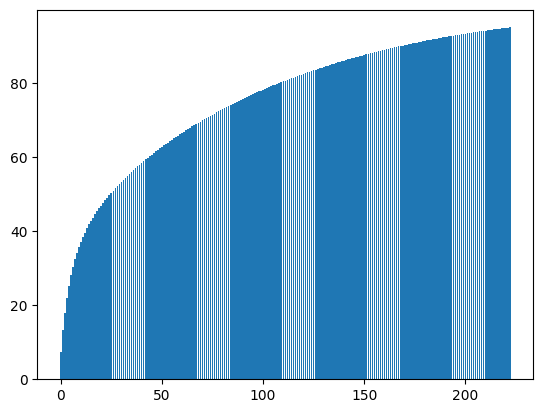

In [39]:
#explained_variance = np.var(pca, axis=0)
#explained_variance_ratio = explained_variance / np.sum(explained_variance)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " components explain around 95% of the variance. From 800 mirs to ", k)

pca = PCA(n_components=k)
mir_cts.pca = pca.fit(mir_cts2)
mir_cts_pca = pca.transform(mir_cts2)
#X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [44]:
X = mir_cts
y = meta2["DFS_STATUS"]
y = y.replace({'0:DiseaseFree':0,'1:Recurred/Progressed':1})
labels = ['0:DiseaseFree', '1:Recurred/Progressed']
#y.replace(to_replace=['Solid Tissue Normal', 'Primary Tumor'], value=[0,1],inplace=True)
y.value_counts()

DFS_STATUS
0    296
1    124
Name: count, dtype: int64

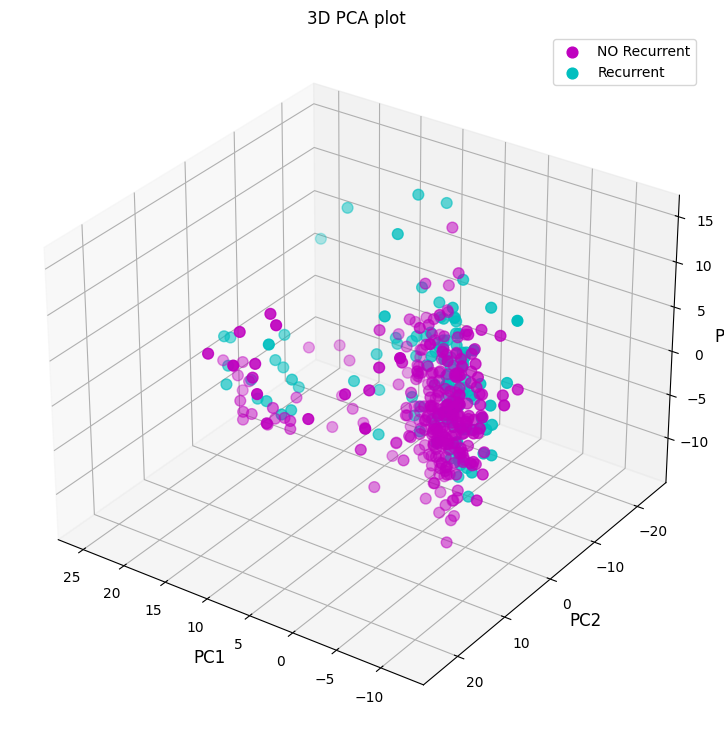

In [41]:
pca3 = PCA(n_components=3).fit(X)
X_reduced = pca3.transform(X)
Xax = X_reduced[:,0]
Yax = X_reduced[:,1]
Zax = X_reduced[:,2]

cdict = {0:'m',1:'c'}
label = {0:'NO Recurrent',1:'Recurrent'}

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')
 
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            c=cdict[l], 
            s=60,
           label=label[l])
 
ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(336, 800)
(336,)
(84, 800)
(84,)
DFS_STATUS
0    237
1     99
Name: count, dtype: int64
DFS_STATUS
0    59
1    25
Name: count, dtype: int64


GaussianNB
accuracy 0.65
f1 score 0.36
ROC AUC 0.56
PR AUC 0.33


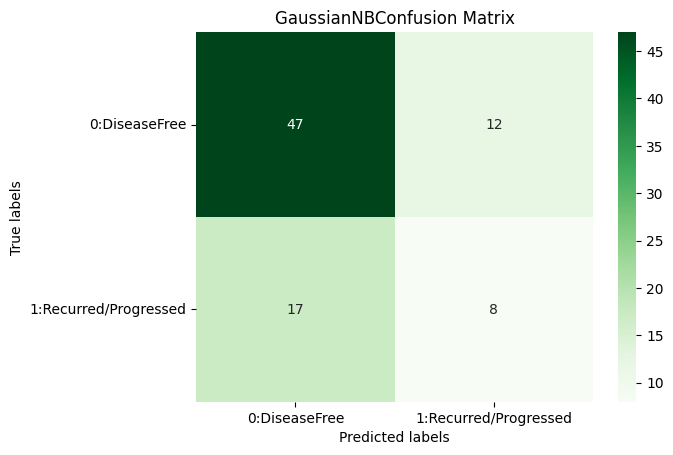

RandomForestClassifier
accuracy 0.71
f1 score 0.08
ROC AUC 0.52
PR AUC 0.33


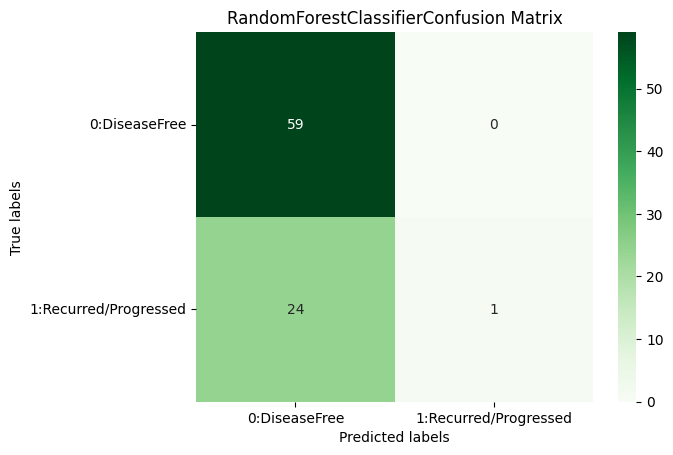

LogisticRegression
accuracy 0.76
f1 score 0.62
ROC AUC 0.73
PR AUC 0.49


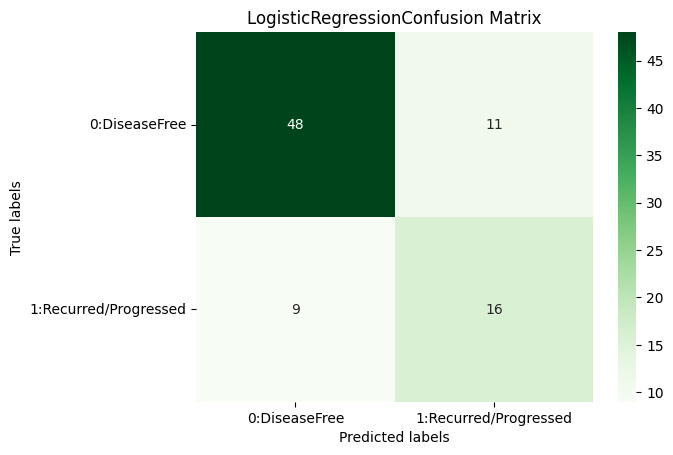

KNeighborsClassifier
accuracy 0.7
f1 score 0.0
ROC AUC 0.5
PR AUC 0.3


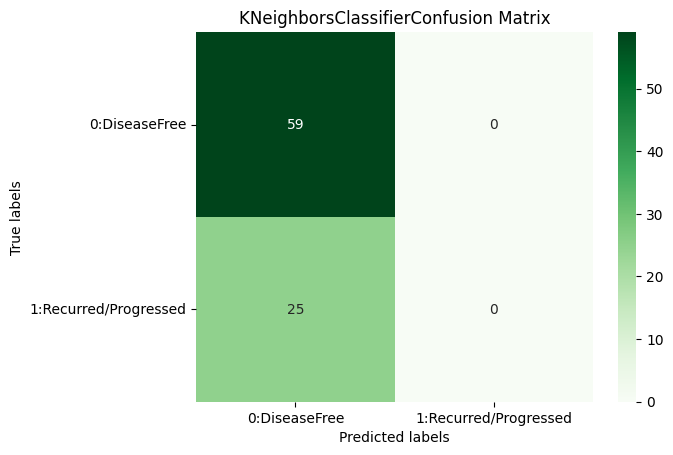

SVC
accuracy 0.71
f1 score 0.08
ROC AUC 0.52
PR AUC 0.33


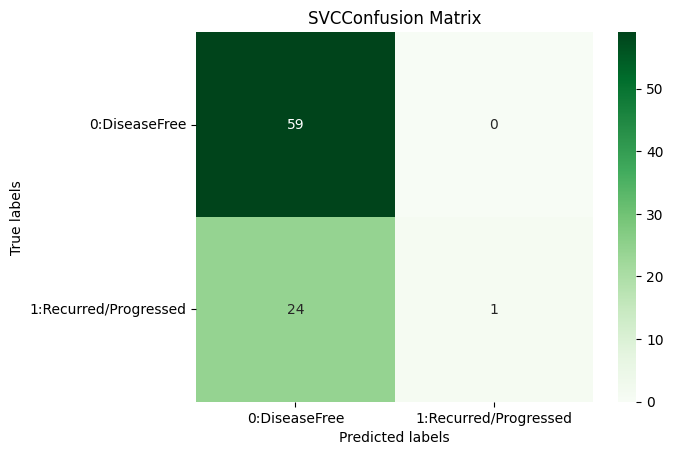

In [46]:
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, average_precision_score, matthews_corrcoef
import xgboost as xgb

# three model variables with middle parameters as possible
clf1 = GaussianNB()
clf2 = RandomForestClassifier(random_state=0, n_jobs=20, n_estimators=500, class_weight="balanced_subsample")
clf3 = LogisticRegression(max_iter=1000, C=0.001,class_weight="balanced")
clf4 = KNeighborsClassifier(n_neighbors=25)
clf5 = SVC(kernel='poly', degree=2)
#clf6 = xgb.XGBClassifier()


models =[clf1, clf2, clf3, clf4, clf5]

# use of 5 quality metrics to be used in k fold cross validation
scoring = {'acc' : make_scorer(accuracy_score),
           'f1' : make_scorer(f1_score), 
           'roc_auc' : make_scorer(roc_auc_score),
           'PR_auc' : make_scorer(average_precision_score),
           'matcf': make_scorer(matthews_corrcoef)}

# loop through the three models and fit all X, y and evaluate the model using 5 kfold cross validation
# and store each type of score range in a list then store total scores for each model in a dictionary
score = []
for clf in models:
    # Fine-tune the hyperparameters
    clf.fit(X_train, y_train)

    # Make predictions using the optimised parameters
    clf_pred = clf.predict(X_test)

    print(clf.__class__.__name__)
    print("accuracy", round(accuracy_score(y_test, clf_pred), 2))
    print("f1 score", round(f1_score(y_test, clf_pred), 2))
    print("ROC AUC", round(roc_auc_score(y_test, clf_pred), 2))
    print("PR AUC", round(average_precision_score(y_test, clf_pred), 2))
    
    score.append(round(average_precision_score(y_test, clf_pred), 2))
    cm = confusion_matrix(y_test, clf_pred)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens') 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title(str(clf.__class__.__name__) + 'Confusion Matrix') 
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360);
    plt.show()
    

In [29]:
# initiation of the model with the best score
#from sklearn.ensemble import RandomForestClassifier

clf = LogisticRegression(max_iter=1000, C=0.001,class_weight="balanced")

# fit the model on the training data
clf.fit(X_train, y_train)


LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000)

In [30]:
importance = pd.DataFrame(clf.coef_)
#cols = list(X.columns)
importance.columns = X.columns
importance.index = ["mir"]

In [31]:

sort = importance.T.sort_values(by=["mir"], ascending=False)
sort.iloc[:50,]

,mir
hsa-mir-9-3,0.035903
hsa-mir-1269a,0.028867
hsa-mir-4680,0.028123
hsa-mir-574,0.026628
hsa-mir-3622a,0.024552
hsa-mir-149,0.022230
hsa-mir-632,0.021454
hsa-mir-28,0.020345
hsa-mir-4752,0.020143
hsa-mir-320b-2,0.019936


In [32]:
import_genes = sort.iloc[:20,]

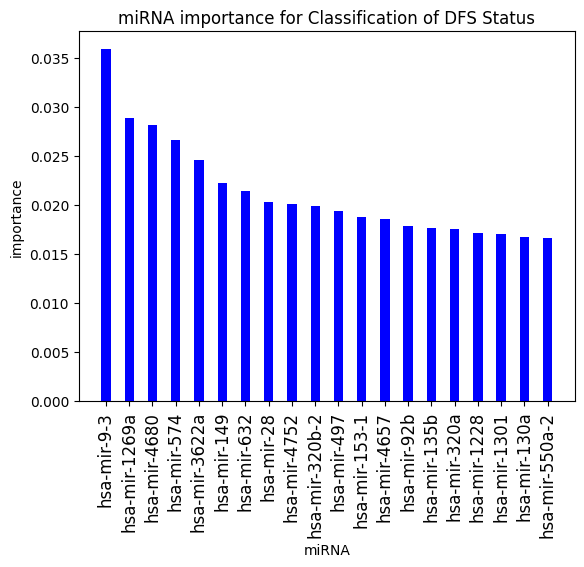

In [33]:
plt.bar(import_genes.index, import_genes["mir"], color ='blue',
        width = 0.4)
plt.xticks(fontsize=12, rotation=90)
plt.xlabel("miRNA")
plt.ylabel("importance")
plt.title("miRNA importance for Classification of DFS Status")
plt.show()

In [34]:
mir_total = pd.concat([X, meta2["DFS_STATUS"]], axis=1)
mir_total.head()

,hsa-mir-4690,hsa-mir-3124,hsa-mir-6715b,hsa-mir-6735,hsa-mir-4680,hsa-mir-6731,hsa-mir-6746,hsa-mir-6764,hsa-mir-6805,hsa-mir-4469,...,hsa-mir-182,hsa-mir-99b,hsa-mir-148a,hsa-mir-10a,hsa-mir-22,hsa-mir-143,hsa-mir-30a,hsa-mir-10b,hsa-mir-21,DFS_STATUS
TCGA-BP-4160,-0.397466,-0.420873,-0.17263,-0.349429,-0.346729,-0.347357,-0.415189,2.310844,-0.307537,-0.413683,...,0.007090,-0.718272,-0.175366,-1.197897,0.097322,0.601133,-0.151157,-0.137760,0.563845,0:DiseaseFree
TCGA-BP-4781,-0.397466,-0.420873,-0.17263,-0.349429,-0.346729,-0.347357,-0.415189,2.331864,-0.307537,-0.413683,...,0.305600,-0.612456,0.744213,0.080995,-0.804571,-1.565976,0.149416,-0.197083,0.808138,0:DiseaseFree
TCGA-CJ-4872,-0.397466,2.344919,-0.17263,-0.349429,-0.346729,-0.347357,-0.415189,-0.394681,-0.307537,-0.413683,...,-0.311481,0.350692,0.459545,0.178571,-0.153065,0.617042,-0.085647,0.876263,0.400047,0:DiseaseFree
TCGA-B8-5553,-0.397466,1.725486,-0.17263,-0.349429,-0.346729,2.043145,-0.415189,-0.394681,-0.307537,-0.413683,...,0.256925,0.780347,0.117673,-0.214025,-0.125325,-0.008033,-0.101855,-0.349558,-0.624268,0:DiseaseFree
TCGA-CJ-5671,-0.397466,1.776232,-0.17263,-0.349429,-0.346729,-0.347357,1.809774,-0.394681,-0.307537,2.994664,...,0.306444,0.239353,0.555223,-0.872513,0.635476,0.511983,-1.974090,-0.173388,0.791565,0:DiseaseFree


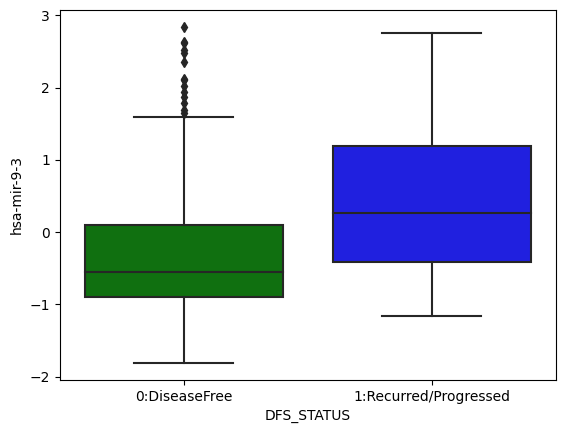

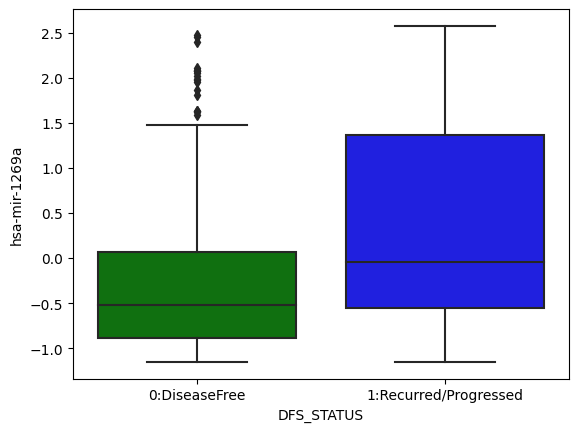

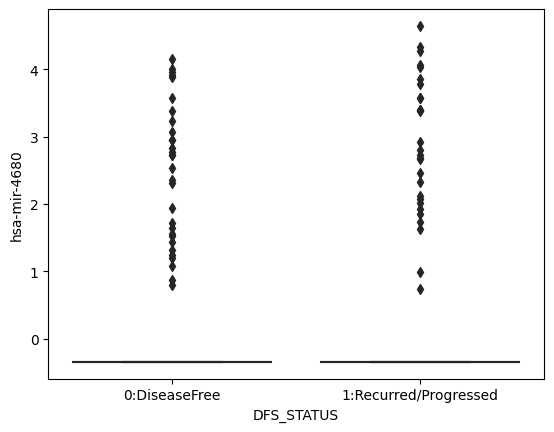

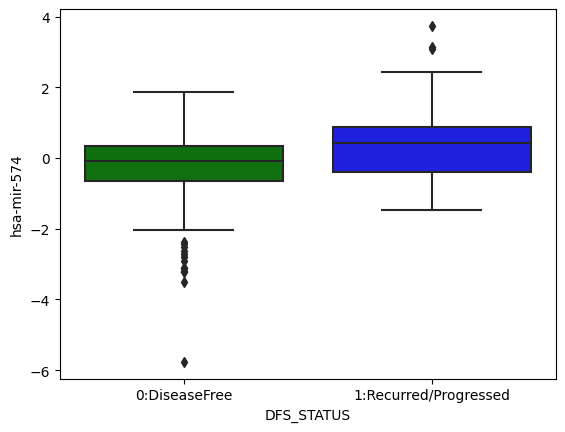

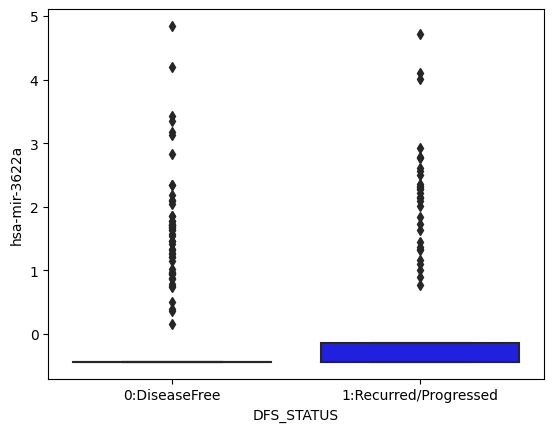

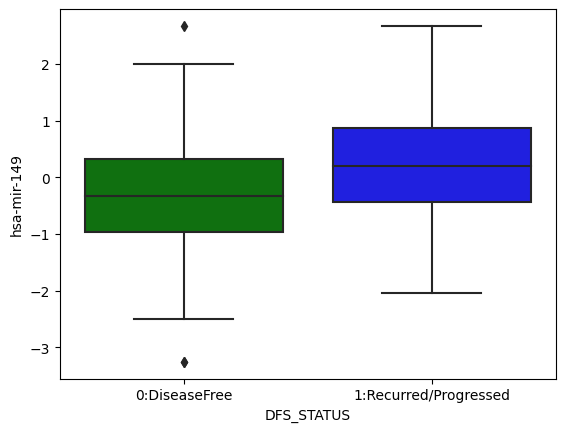

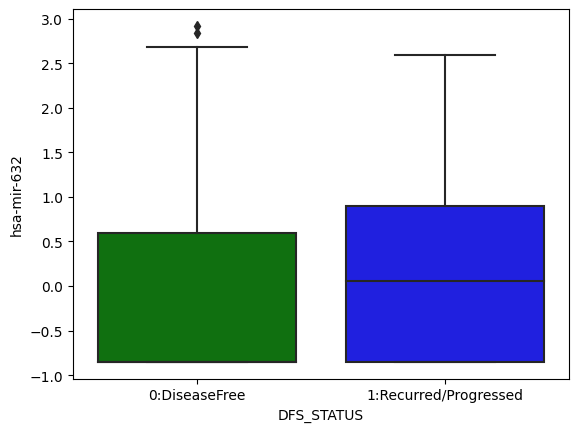

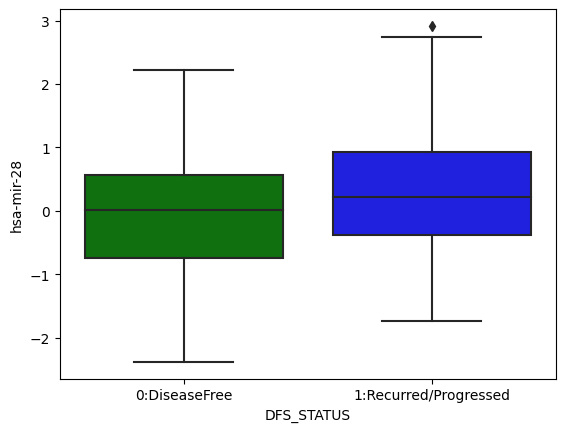

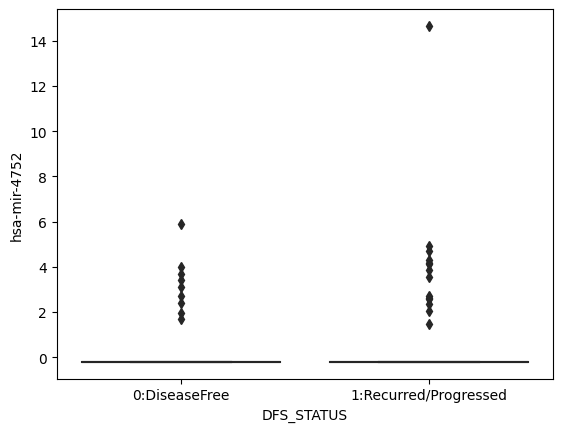

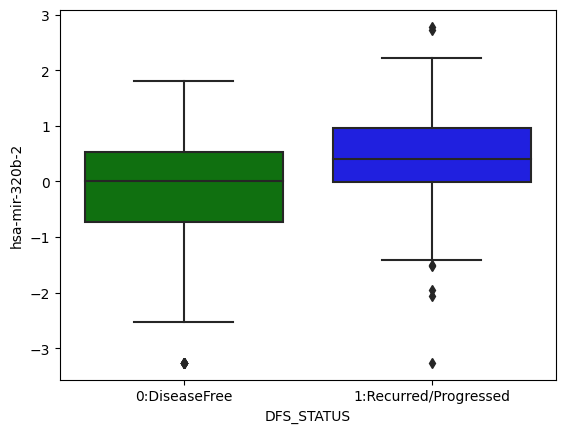

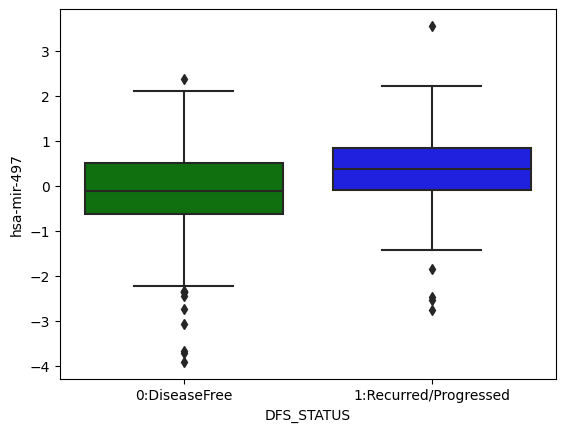

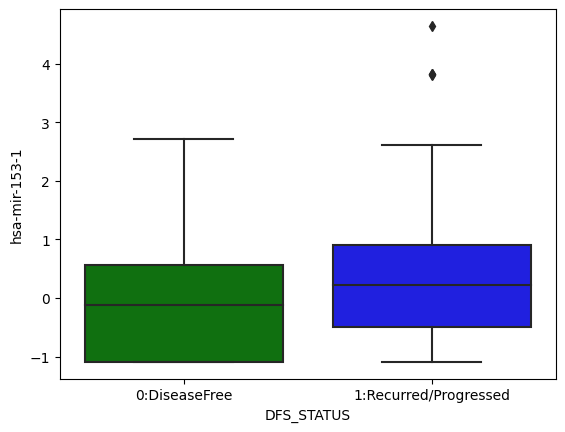

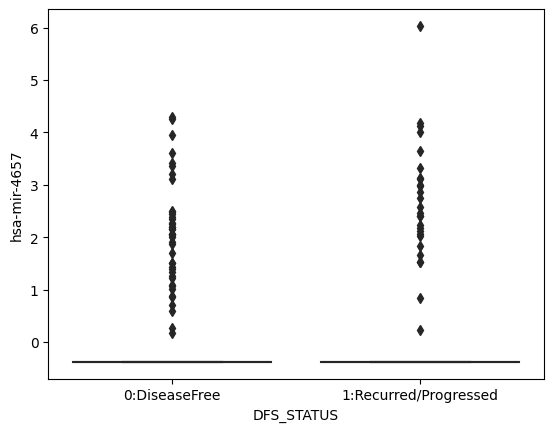

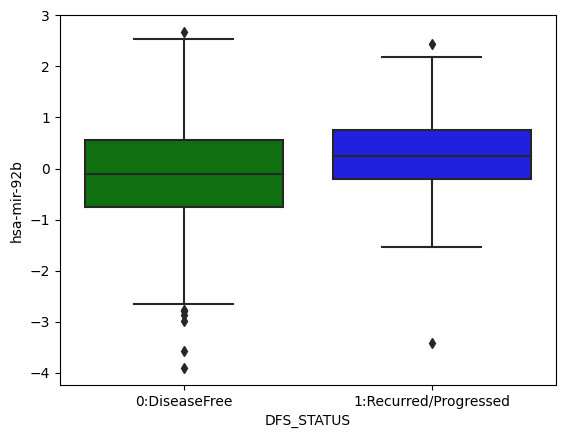

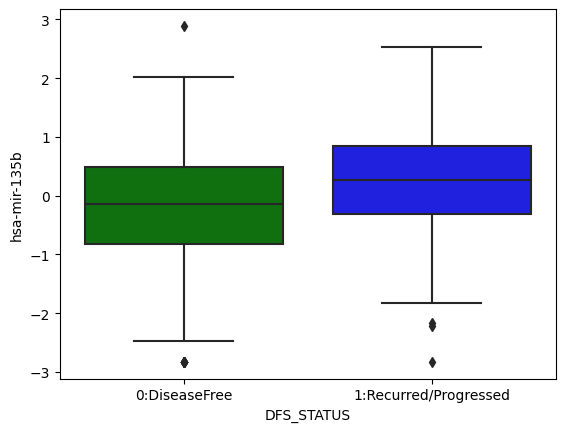

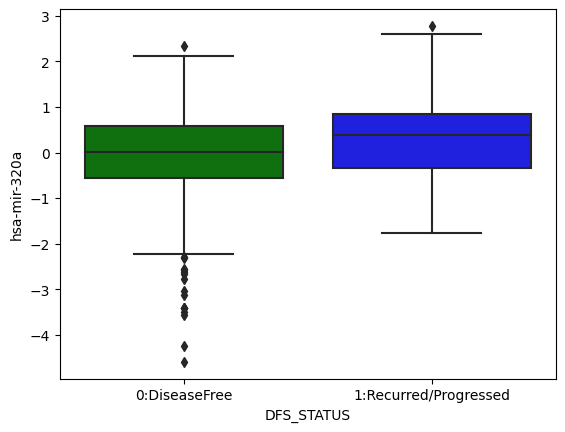

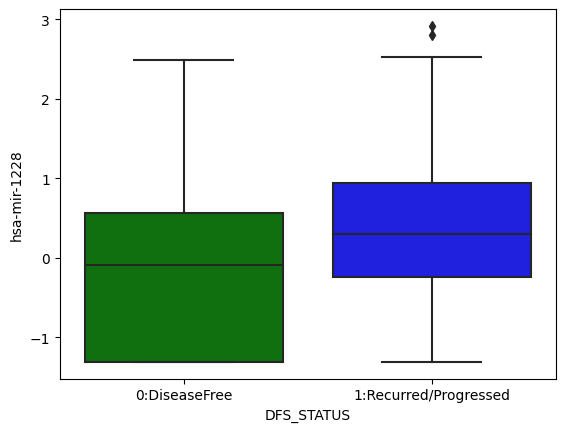

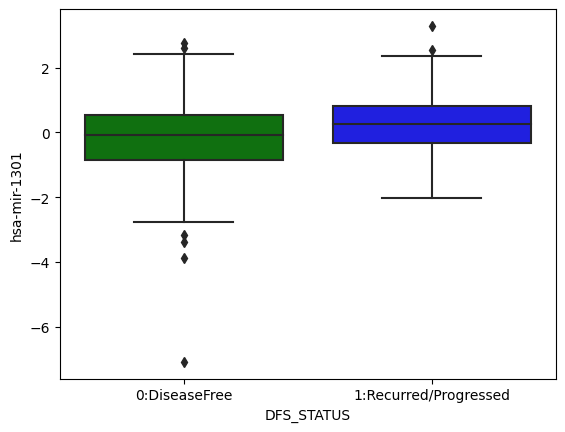

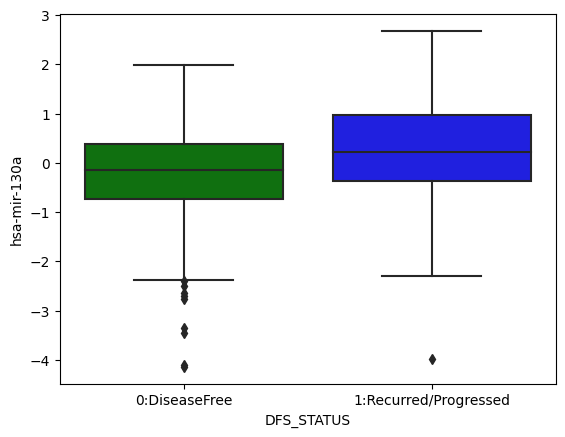

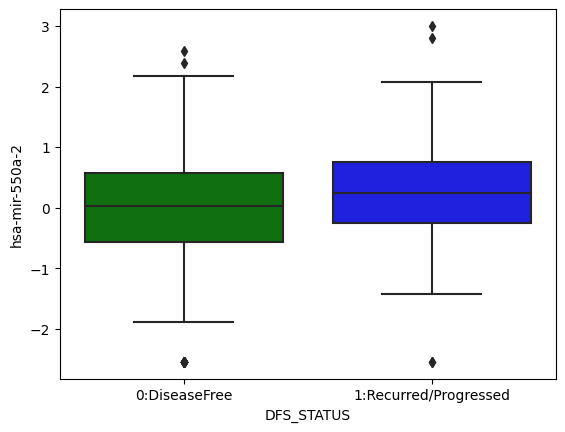

In [35]:
my_pal = {"0:DiseaseFree": "g", "1:Recurred/Progressed": "b"}
for mir in import_genes.index:
    sns.boxplot(data=mir_total, x='DFS_STATUS', y=mir, palette=my_pal)
    plt.show()
    
